In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
import os
import time

from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from keras.models import Model
%tensorflow_version 1.x

In [0]:
data_base_path = "/content/drive/My Drive/labeled/"
imgfile = os.listdir('/content/drive/My Drive/class_art')
save_dir = os.path.abspath("/content/drive/My Drive/Colab Notebooks/")
#train_dir = os.path.join(data_base_path,"train")
#test_dir = os.path.join(data_base_path,"test")
#validate_dir = os.path.join(data_base_path,"validate")

In [6]:
print(len(os.listdir(data_base_path+"water/")))
print(len(os.listdir(data_base_path+"flower/")))

41
41


In [0]:
nb_classes = 6
batch_size = 32
nb_train_samples = batch_size*3
nb_validation_samples = batch_size*1
nb_epochs = 100

#IMAGE_RESIZE = 150
img_height = 150
img_width = 150

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [8]:
# Extract base of VGG16 model:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 1s 0us/step


In [165]:
# Add 3 trainable layers on top:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512*4, activation='relu'))
# EAM added a dropout layer
model.add(Dropout(0.5))
model.add(Dense(512*4, activation='relu'))
# EAM added a dropout layer & an additional model layer
model.add(Dropout(0.3))
model.add(Dense(512*4, activation='relu'))

# predict category
model.add(Dense(nb_classes, activation='softmax'))

conv_base.trainable = True
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 34
This is the number of trainable weights after freezing the conv base: 8


In [0]:
train_gen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True, 
#    vertical_flip=True,
    rotation_range=40, 
    width_shift_range=.15,
    height_shift_range=.15,
    zoom_range=0.5,
    validation_split=0.2) # set validation split

In [11]:
train_generator = train_gen.flow_from_directory(
    data_base_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training') # set as training data
    # shuffles by default

validation_generator = train_gen.flow_from_directory(
    data_base_path, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation') # set as validation data

Found 192 images belonging to 6 classes.
Found 48 images belonging to 6 classes.


In [0]:
sample_training_images, _ = next(train_generator)

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

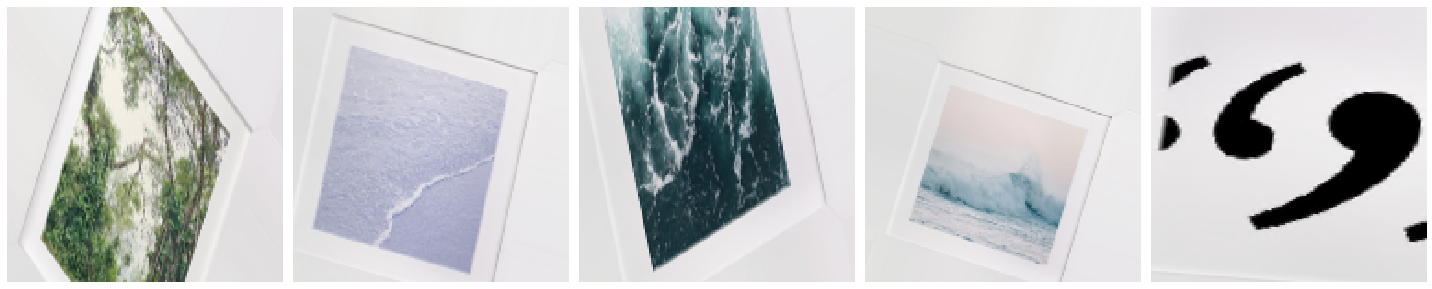

In [14]:
plotImages(sample_training_images[:5])

In [166]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              16779264  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)             

In [0]:
model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy',  # for labeled data
              metrics = ['accuracy'])

In [168]:
start_time = time.time()
fit_history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=nb_epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)
end_time = time.time()
print("Total Time: "+str(end_time - start_time)+" seconds.")

Epoch 1/100
3/3 [==============================] - 3s 849ms/step - loss: 8.4354 - acc: 0.1354 - val_loss: 3.2657 - val_acc: 0.2188
Epoch 2/100
3/3 [==============================] - 1s 280ms/step - loss: 3.0406 - acc: 0.1458 - val_loss: 1.9866 - val_acc: 0.1250
Epoch 3/100
3/3 [==============================] - 1s 384ms/step - loss: 1.8370 - acc: 0.2188 - val_loss: 1.7313 - val_acc: 0.2188
Epoch 4/100
3/3 [==============================] - 1s 365ms/step - loss: 1.8350 - acc: 0.1875 - val_loss: 1.7344 - val_acc: 0.2188
Epoch 5/100
3/3 [==============================] - 1s 355ms/step - loss: 1.7558 - acc: 0.2083 - val_loss: 1.6760 - val_acc: 0.4688
Epoch 6/100
3/3 [==============================] - 1s 397ms/step - loss: 1.7263 - acc: 0.3333 - val_loss: 1.4822 - val_acc: 0.5312
Epoch 7/100
3/3 [==============================] - 1s 370ms/step - loss: 1.4373 - acc: 0.4375 - val_loss: 1.4226 - val_acc: 0.5625
Epoch 8/100
3/3 [==============================] - 1s 370ms/step - loss: 1.4646 - a

In [169]:
#save_dir = os.path.join(os.getcwd(),'/drive/My Drive/Colab Notebooks/models/')
print(save_dir)

/content/drive/My Drive/Colab Notebooks


In [0]:
import pickle
model.save(save_dir+'/VGG_classifier_v4.h5')
fit_history.history['time_total'] = end_time - start_time
pickle.dump(fit_history.history,open(save_dir+'/VGG_classifier_v4.pkl','wb'))

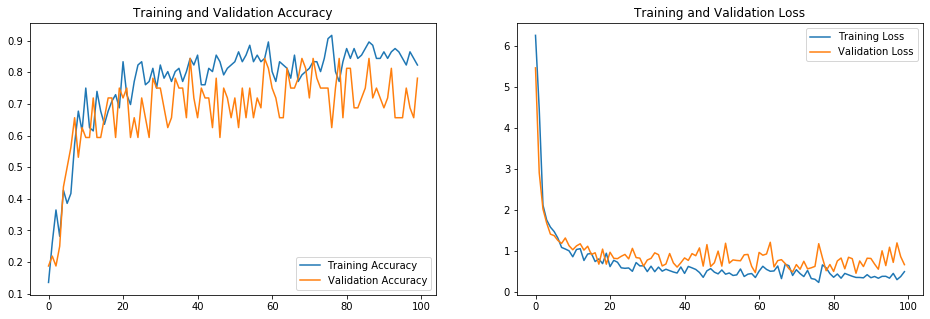

In [20]:
#print(fit_history.history.keys())
acc = fit_history.history['acc']
val_acc = fit_history.history['val_acc']

loss = fit_history.history['loss']
val_loss = fit_history.history['val_loss']

epochs_range = range(nb_epochs)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./VGG.class.v4.png')
plt.show()

In [0]:
model.save('VGG.class.v4.png')

In [0]:
import random
import numpy as np
import matplotlib.pyplot as plt
def load_image(path):
    img = image.load_img(path,target_size=model.input_shape[1:3])
    x= image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x= preprocess_input(x)
    return img,x

In [173]:
# this is a hook (learned about it here: https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903/13)
# hooks are used for saving intermediate computations
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()
        
sf = SaveFeatures(model.model[1][5]) ## Output before the last FC layer

AttributeError: ignored

In [174]:
## By running this feature vectors would be saved in sf variable initated above
_= model.get_preds(data.train_ds)
_= model.get_preds(DatasetType.Valid)

AttributeError: ignored

In [0]:
import h5py
import os

In [0]:
imgfile = os.listdir('/content/drive/My Drive/class_art/')

In [0]:
#imgfile

In [0]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

img = image.load_img('/content/drive/My Drive/class_art/'+imgfile[18], target_size=(150,150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)


shape of x:  (1, 150, 150, 3)
data type: float32


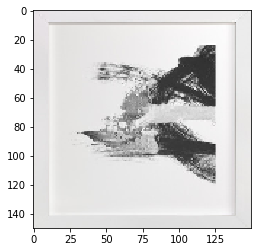

In [181]:
plt.imshow(img)
print("shape of x: ", x.shape)
print("data type:",x.dtype)

In [182]:

predictions = model.predict(x)
#decode_predictions(predictions)
predictions

array([[0.0000000e+00, 0.0000000e+00, 1.8525244e-06, 5.1360221e-36,
        9.9999809e-01, 0.0000000e+00]], dtype=float32)

In [38]:
featurestest

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        1.6836713e-08, 0.0000000e+00]], dtype=float32)

In [39]:
x

array([[[[119.061, 108.221, 101.32 ],
         [120.061, 109.221, 102.32 ],
         [120.061, 109.221, 102.32 ],
         ...,
         [132.061, 119.221, 112.32 ],
         [130.061, 117.221, 110.32 ],
         [130.061, 117.221, 110.32 ]],

        [[115.061, 104.221,  97.32 ],
         [118.061, 107.221, 100.32 ],
         [118.061, 107.221, 100.32 ],
         ...,
         [132.061, 119.221, 112.32 ],
         [133.061, 120.221, 113.32 ],
         [125.061, 112.221, 105.32 ]],

        [[117.061, 106.221,  99.32 ],
         [117.061, 106.221,  99.32 ],
         [119.061, 108.221, 101.32 ],
         ...,
         [132.061, 119.221, 112.32 ],
         [123.061, 110.221, 103.32 ],
         [135.061, 122.221, 115.32 ]],

        ...,

        [[123.061, 110.221, 103.32 ],
         [119.061, 108.221, 101.32 ],
         [119.061, 108.221, 101.32 ],
         ...,
         [118.061, 101.221,  99.32 ],
         [125.061, 108.221, 106.32 ],
         [127.061, 110.221, 108.32 ]],

        [[

In [40]:
from tensorflow.keras import backend as K

# with a Sequential model
get_11th_layer_output = K.function([model.layers[0].input],
                                  [model.layers[11].output])
featuresize = np.shape(get_11th_layer_output([x])[0])
#print(get_11th_layer_output([x]))
#layer_output = get_14th_layer_output([x])[0]

IndexError: ignored